In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
from datasets import load_dataset

# Load MNIST-M dataset
ds = load_dataset("Mike0307/MNIST-M")
train_data = ds['train']
test_data = ds['test']

X_train_m = np.array([np.array(image.resize((28, 28))) for image in train_data['image']])
y_train_m = np.array(train_data['label'])
X_test_m = np.array([np.array(image.resize((28, 28))) for image in test_data['image']])
y_test_m = np.array(test_data['label'])

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess MNIST
X_train = X_train.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
X_train = np.repeat(X_train, 3, axis=-1)  # Convert to 3 channels
X_test = np.repeat(X_test, 3, axis=-1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Preprocess MNIST-M
X_train_m = X_train_m.astype(np.float32)/255
X_test_m = X_test_m.astype(np.float32)/255
y_train_m = to_categorical(y_train_m)
y_test_m = to_categorical(y_test_m)

print('MNIST shapes:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print('MNIST-M shapes:', X_train_m.shape, y_train_m.shape, X_test_m.shape, y_test_m.shape)

c:\Users\anshb\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MNIST shapes: (60000, 28, 28, 3) (60000, 10) (10000, 28, 28, 3) (10000, 10)
MNIST-M shapes: (59001, 28, 28, 3) (59001, 10) (9001, 28, 28, 3) (9001, 10)


In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(28, 28, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
features = Dense(128, activation='relu')(x)

feature_model = Model(inputs=input_layer, outputs=features)

feature_input = Input(shape=(128,))
x = Dropout(0.3)(feature_input)
predictions = Dense(10, activation='softmax')(x)
classifier_model = Model(inputs=feature_input, outputs=predictions)

classifier_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [3]:
classifier_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290 (5.04 KB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
feature_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,728 (944.25 KB)

 Trainable params: 241,280 (942.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K

def coral_loss(source, target, scale_loss=1e4):
    batch_size = tf.cast(tf.shape(source)[0], tf.float32)
    d = tf.cast(tf.shape(source)[1], tf.float32)

    source_c = source - tf.reduce_mean(source, axis=0)
    target_c = target - tf.reduce_mean(target, axis=0)

    source_cov = tf.matmul(source_c, source_c, transpose_a=True) / (batch_size - 1.0)
    target_cov = tf.matmul(target_c, target_c, transpose_a=True) / (batch_size - 1.0)
    source_cov += tf.eye(tf.shape(source_cov)[0]) * 1e-5
    target_cov += tf.eye(tf.shape(target_cov)[0]) * 1e-5

    loss = tf.reduce_sum(tf.square(source_cov - target_cov)) / (4.0 * d * d)
    return loss * scale_loss  


In [7]:
import tensorflow as tf

def gaussian_kernel(x, y, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """Compute a multi-scale Gaussian kernel between x and y."""
    total = tf.concat([x, y], axis=0)
    total0 = tf.expand_dims(total, axis=0)
    total1 = tf.expand_dims(total, axis=1)

    L2_distance = tf.reduce_sum(tf.square(total0 - total1), axis=-1)

    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = tf.reduce_mean(L2_distance)  # better than *10.0

    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    kernel_val = [tf.exp(-L2_distance / (bw + 1e-8)) for bw in bandwidth_list]

    return sum(kernel_val) / len(kernel_val)

def mmd_loss(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """Compute the MMD loss between source and target feature distributions."""
    batch_size = tf.shape(source)[0]
    kernels = gaussian_kernel(source, target, kernel_mul, kernel_num, fix_sigma)

    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]

    loss = tf.reduce_mean(XX + YY - XY - YX)
    return tf.maximum(loss, 1e-8)  # ensures non-negativity and stability


In [8]:
def train_model(
    source_x, source_y, target_x, target_y=None,
    feature_model=None, classifier_model=None,
    epochs=10, batch_size=64, lambda_da=0.5,
    validation_data=None, validation_samples=8000,
    early_stopping_patience=7, type_loss='coral',
    lambda_mmd=1.0, lambda_coral=1.0
):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    best_target_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        class_loss_total, da_loss_total = 0.0, 0.0

        idx_source = tf.random.shuffle(tf.range(len(source_x)))
        idx_target = tf.random.shuffle(tf.range(len(target_x)))
        num_batches = min(len(source_x) // batch_size, len(target_x) // batch_size)

        for batch in range(num_batches):
            start = batch * batch_size
            end = start + batch_size

            with tf.GradientTape() as tape:
                # Batch selection
                source_x_batch = tf.gather(source_x, idx_source[start:end])
                source_y_batch = tf.gather(source_y, idx_source[start:end])
                target_x_batch = tf.gather(target_x, idx_target[start:end])

                # Forward pass
                source_features = feature_model(source_x_batch, training=True)
                target_features = feature_model(target_x_batch, training=True)
                source_pred = classifier_model(source_features, training=True)

                # Loss computation
                class_loss = tf.reduce_mean(
                    tf.keras.losses.categorical_crossentropy(source_y_batch, source_pred)
                )

                # Domain alignment loss
                da_loss = 0.0
                if 'mmd' in type_loss:
                    da_loss += lambda_mmd * mmd_loss(source_features, target_features)
                if 'coral' in type_loss:
                    da_loss += lambda_coral * coral_loss(source_features, target_features)

                total_loss = class_loss + lambda_da * da_loss

            # Backpropagation
            trainable_vars = feature_model.trainable_variables + classifier_model.trainable_variables
            gradients = tape.gradient(total_loss, trainable_vars)
            gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
            optimizer.apply_gradients(zip(gradients, trainable_vars))

            class_loss_total += class_loss.numpy()
            da_loss_total += da_loss.numpy()

        # Logging
        avg_class_loss = class_loss_total / num_batches
        avg_da_loss = da_loss_total / num_batches
        print(f"Class Loss: {avg_class_loss:.4f}, DA Loss: {avg_da_loss:.4f}")

        # Validation
        if validation_data is not None:
            X_test_m, y_test_m = validation_data
            val_indices = tf.range(validation_samples)

            target_features_val = feature_model(tf.gather(X_test_m, val_indices), training=False)
            target_pred = classifier_model(target_features_val, training=False)
            target_acc = tf.reduce_mean(
                tf.keras.metrics.categorical_accuracy(tf.gather(y_test_m, val_indices), target_pred)
            ).numpy()

            source_features_val = feature_model(tf.gather(source_x, val_indices), training=False)
            source_pred = classifier_model(source_features_val, training=False)
            source_acc = tf.reduce_mean(
                tf.keras.metrics.categorical_accuracy(tf.gather(source_y, val_indices), source_pred)
            ).numpy()

            print(f"Source Acc: {source_acc:.4f}, Target Acc: {target_acc:.4f}")

            # Early stopping
            if target_acc > best_target_acc:
                best_target_acc = target_acc
                patience_counter = 0
                feature_model.save_weights('best_feature_model.weights.h5')
                classifier_model.save_weights('best_classifier.weights.h5')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break

    return feature_model, classifier_model


In [9]:
feature_model_both, classifier_model_both = train_model(
    source_x=X_train,
    source_y=y_train,
    target_x=X_train_m,
    feature_model=feature_model,
    classifier_model=classifier_model,
    epochs=20,
    batch_size=64,
    lambda_da=0.5,
    type_loss='mmd+coral',
    lambda_mmd=1.0,
    lambda_coral=1.0,
    validation_data=(X_test_m, y_test_m)
)



Epoch 1/20
Class Loss: 0.5487, DA Loss: 0.5623
Source Acc: 0.9795, Target Acc: 0.5372

Epoch 2/20
Class Loss: 0.1613, DA Loss: 0.1913
Source Acc: 0.9855, Target Acc: 0.6051

Epoch 3/20
Class Loss: 0.1048, DA Loss: 0.1257
Source Acc: 0.9900, Target Acc: 0.6555

Epoch 4/20
Class Loss: 0.0817, DA Loss: 0.0927
Source Acc: 0.9925, Target Acc: 0.6815

Epoch 5/20
Class Loss: 0.0611, DA Loss: 0.0685
Source Acc: 0.9934, Target Acc: 0.6631

Epoch 6/20
Class Loss: 0.0503, DA Loss: 0.0556
Source Acc: 0.9961, Target Acc: 0.6504

Epoch 7/20
Class Loss: 0.0389, DA Loss: 0.0426
Source Acc: 0.9951, Target Acc: 0.6716

Epoch 8/20
Class Loss: 0.0340, DA Loss: 0.0357
Source Acc: 0.9931, Target Acc: 0.6584

Epoch 9/20
Class Loss: 0.0300, DA Loss: 0.0312
Source Acc: 0.9976, Target Acc: 0.6826

Epoch 10/20
Class Loss: 0.0243, DA Loss: 0.0274
Source Acc: 0.9977, Target Acc: 0.6630

Epoch 11/20
Class Loss: 0.0223, DA Loss: 0.0246
Source Acc: 0.9974, Target Acc: 0.6614

Epoch 12/20
Class Loss: 0.0188, DA Loss:

In [10]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Step 1: Extract features from target domain
target_features_both = feature_model_both(X_test_m, training=False)

# Step 2: Get class probabilities from the classifier
y_pred_probs = classifier_model_both(target_features_both, training=False)

# Step 3: Take the class with max probability as prediction
y_pred_both = np.argmax(y_pred_probs, axis=1)

# Step 4: Convert one-hot test labels to integers if needed
y_test_labels = np.argmax(y_test_m, axis=1)

# Step 5: Evaluate
accuracy = accuracy_score(y_test_labels, y_pred_both)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_both))


Test Accuracy: 63.88%
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       878
           1       0.89      0.64      0.74      1016
           2       0.58      0.70      0.63       933
           3       0.44      0.70      0.54       908
           4       0.97      0.56      0.71       890
           5       0.65      0.70      0.68       807
           6       0.94      0.61      0.74       856
           7       0.42      0.70      0.53       914
           8       0.64      0.54      0.58       880
           9       0.78      0.61      0.68       919

    accuracy                           0.64      9001
   macro avg       0.70      0.64      0.65      9001
weighted avg       0.70      0.64      0.65      9001



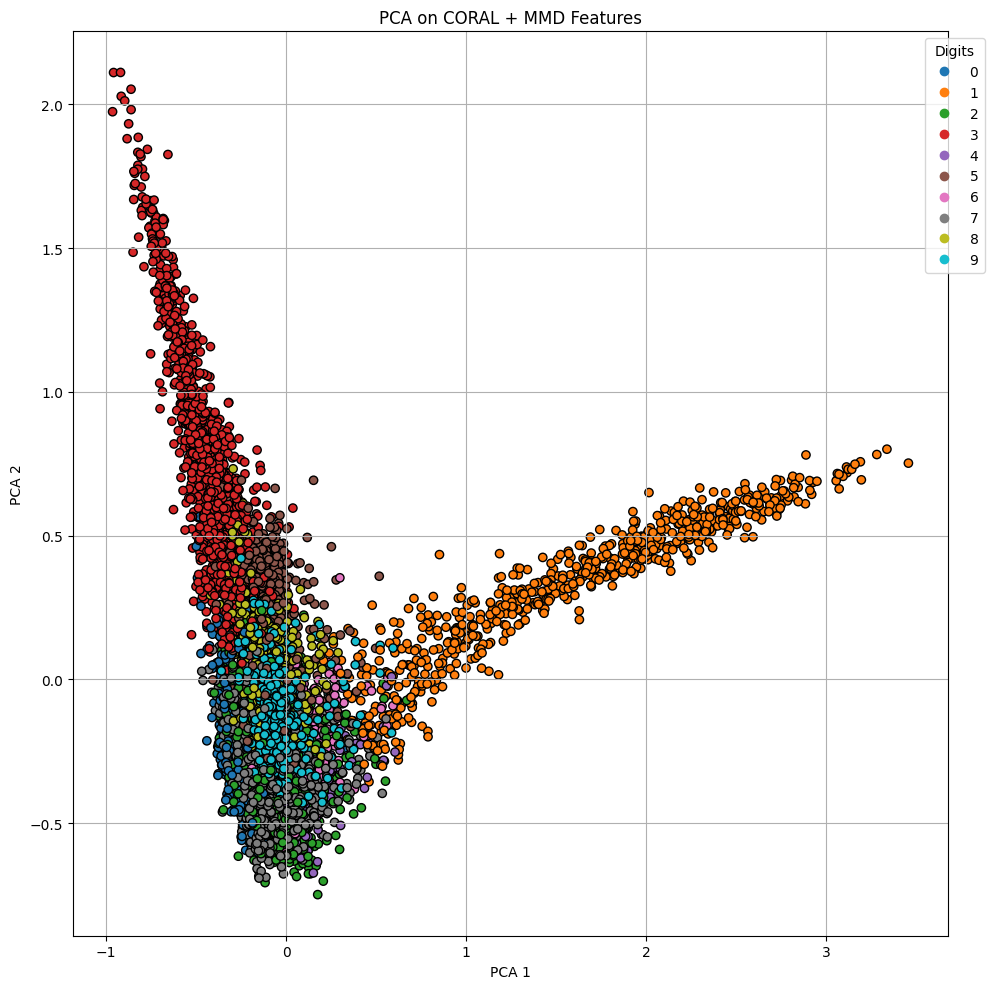

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure your test data is a NumPy array or eager tensor
X_test_m_np = X_test_m.numpy() if hasattr(X_test_m, 'numpy') else X_test_m

# Get actual feature outputs from model
target_features_both = feature_model_both(X_test_m_np, training=False)

# Convert to NumPy
if isinstance(target_features_both, tf.Tensor):
    features = target_features_both.numpy()
else:
    features = target_features_both

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Plot
plt.figure(figsize=(10, 10))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_pred_both, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("PCA on CORAL + MMD Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


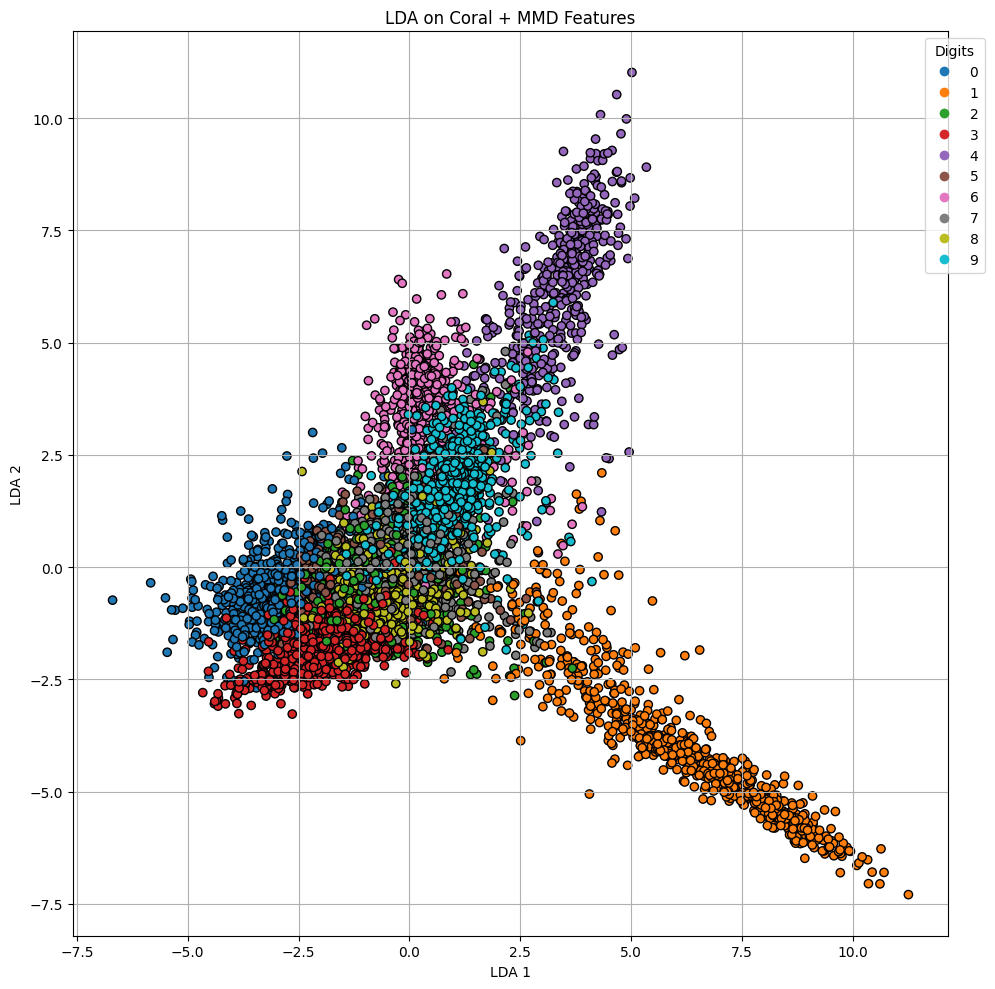

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
lda_result = lda.fit_transform(features, y_pred_both)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(lda_result[:, 0], lda_result[:, 1], c=y_pred_both, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("LDA on Coral + MMD Features")
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\anshb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


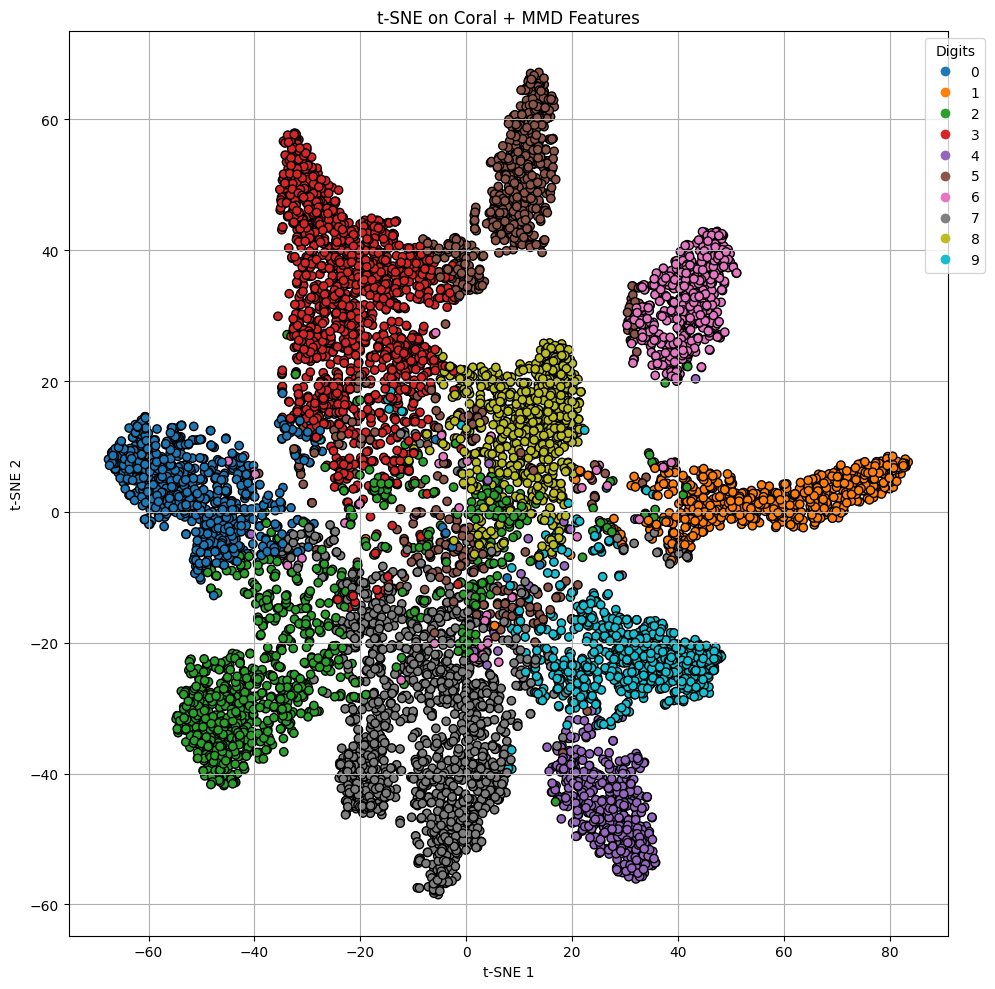

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_pred_both, cmap='tab10', edgecolors='k')
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1))
plt.title("t-SNE on Coral + MMD Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


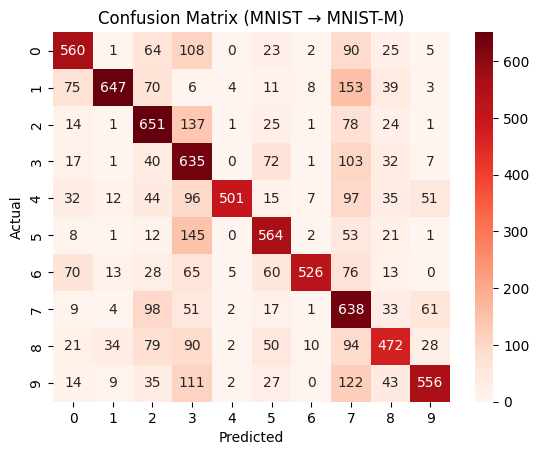

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if len(y_test_m.shape) > 1:
    y_test_m_labels = np.argmax(y_test_m, axis=1)
else:
    y_test_m_labels = y_test_m

if len(y_pred_both.shape) > 1:
    y_pred_both_labels = np.argmax(y_pred_both, axis=1)
else:
    y_pred_both_labels = y_pred_both

cm = confusion_matrix(y_test_m_labels, y_pred_both_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (MNIST → MNIST-M)")
plt.show()


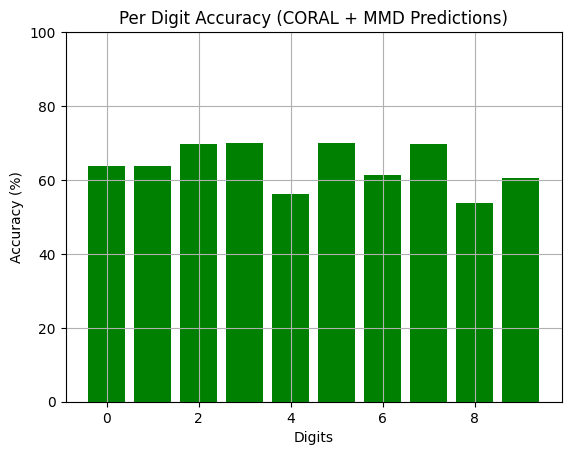

In [15]:
import numpy as np
import matplotlib.pyplot as plt

y_true = np.argmax(y_test_m, axis=1)
y_pred = y_pred_both

accuracies = []
for digit in range(10):
    idx = (y_true == digit)
    correct = (y_pred[idx] == digit).sum()
    total = idx.sum()
    accuracies.append(correct / total * 100)

plt.bar(range(10), accuracies, color='green')
plt.xlabel("Digits")
plt.ylabel("Accuracy (%)")
plt.title("Per Digit Accuracy (CORAL + MMD Predictions)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


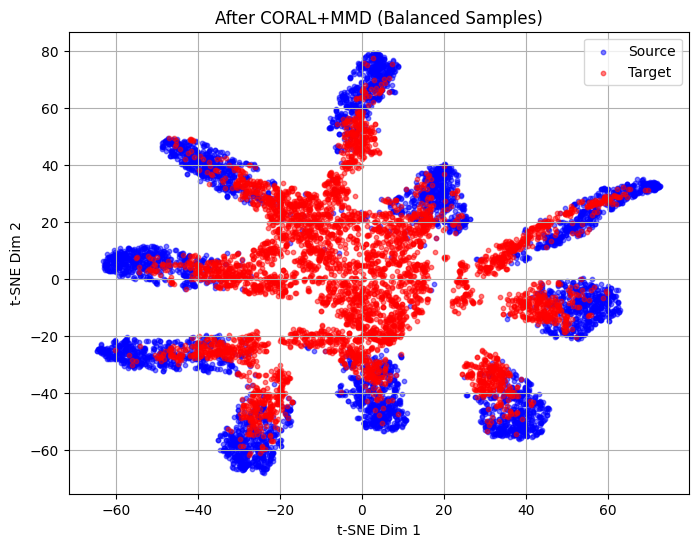

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_domain_alignment(source_features, target_features, title='Domain Alignment'):
  
    all_features = np.concatenate([source_features, target_features], axis=0)
    
    domain_labels = np.array([0]*len(source_features) + [1]*len(target_features))
    
    tsne = TSNE(n_components=2, perplexity=50, random_state=42)
    reduced = tsne.fit_transform(all_features)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[domain_labels == 0, 0], reduced[domain_labels == 0, 1], 
                label='Source', alpha=0.5, s=10, c='blue')
    plt.scatter(reduced[domain_labels == 1, 0], reduced[domain_labels == 1, 1], 
                label='Target', alpha=0.5, s=10, c='red')
    plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.grid(True)
    plt.show()

def balanced_sample(X, y, samples_per_class=700):
    selected = []
    for digit in range(10):
        indices = np.where(np.argmax(y, axis=1) == digit)[0]
        selected.extend(np.random.choice(indices, samples_per_class, replace=False))
    return X[selected], y[selected]

# Balanced sampling: 500 per class → 5000 total
X_src_bal, y_src_bal = balanced_sample(X_train, y_train, samples_per_class=500)
X_tgt_bal, y_tgt_bal = balanced_sample(X_train_m, y_train_m, samples_per_class=500)

features_src = feature_model_both.predict(X_src_bal)
features_tgt = feature_model_both.predict(X_tgt_bal)
plot_domain_alignment(features_src, features_tgt, title='After CORAL+MMD (Balanced Samples)')
